# Mission Gargantua: Numerical Analysis of Gravitational Time Dilation

## Objective
In this notebook, we analyze sensor measurements of gravitational time dilation near a massive black hole (Gargantua). We aim to:
1. Fit a **Rational Model** to noisy data using **Linear Least Squares** (implemented via Matrix Operations).
2. Analyze the quality of the fit (MSE and Residuals).
3. Estimate the proper time accumulated along a trajectory using **Numerical Integration** (Trapezoidal, Simpson's 1/3, and Simpson's 3/8).

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set plot style for clarity
plt.style.use('ggplot')

## 1. Data Loading & Preparation

First, we ensure the data exists. The block below generates the dataset based on the specifications provided, saves it to CSV, and then loads it for analysis.

In [2]:
# --- STEP 1: GENERATE DATA (Ensuring reproducibility) ---
def generate_data():
    G = 6.67430e-11
    M_sun = 1.989e30
    M = 100e6 * M_sun
    c = 2.998e8
    Rs = (2 * G * M) / (c**2)
    
    n_samples = 50
    r_measurements = np.linspace(1.5 * Rs, 50 * Rs, n_samples)
    y_true = np.sqrt(1 - (Rs / r_measurements))
    
    np.random.seed(42)
    noise = np.random.normal(0, 0.02 * np.mean(y_true), n_samples)
    y_measured = np.clip(y_true + noise, 0.001, 0.999)
    
    df_gen = pd.DataFrame({
        'radius_km': r_measurements / 1000,
        'dilation_factor_measured': y_measured
    })
    df_gen.to_csv('mission_gargantua_sensor_data.csv', index=False)
    print("Data generated and saved to 'mission_gargantua_sensor_data.csv'.")

generate_data()

# --- STEP 2: LOAD DATA ---
df = pd.read_csv('mission_gargantua_sensor_data.csv')

# Extract vectors
r_data = df['radius_km'].values
F_data = df['dilation_factor_measured'].values

print(f"Loaded {len(df)} samples.")
print(df.head())

Data generated and saved to 'mission_gargantua_sensor_data.csv'.
Loaded 50 samples.
      radius_km  dilation_factor_measured
0  4.430967e+08                  0.586864
1  7.354802e+08                  0.770890
2  1.027864e+09                  0.856567
3  1.320247e+09                  0.910223
4  1.612631e+09                  0.899298


## 2. Model Selection & Feature Engineering

We observe that the physical relationship involves $1/r$. A purely linear polynomial $F(r) = mx + c$ would fit poorly because the relationship is asymptotic.

Instead, we choose a **Rational/Inverse Model**:
$$ F(r) \approx c_0 + c_1 \left(\frac{1}{r}\right) $$

This allows us to use **Linear Least Squares** by creating a new feature $x' = 1/r$. The model becomes linear in its parameters:
$$ y = \beta_0 + \beta_1 x' $$

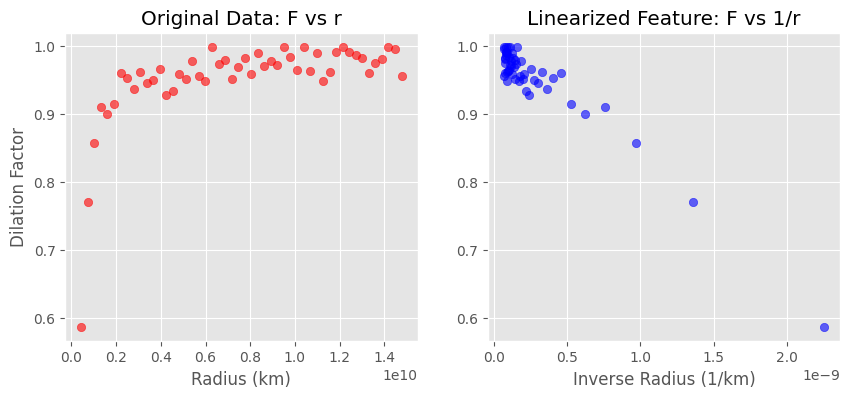

In [3]:
# Feature Engineering: Create the 1/r term
inv_r = 1.0 / r_data

# Visual check of linearization
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(r_data, F_data, color='red', alpha=0.6)
plt.title("Original Data: F vs r")
plt.xlabel("Radius (km)")
plt.ylabel("Dilation Factor")

plt.subplot(1, 2, 2)
plt.scatter(inv_r, F_data, color='blue', alpha=0.6)
plt.title("Linearized Feature: F vs 1/r")
plt.xlabel("Inverse Radius (1/km)")
plt.show()

## 3. Matrix Least Squares Implementation

We solve for the parameters $\vec{\beta}$ using the Normal Equations:
$$ A^T A \vec{\beta} = A^T \vec{y} $$
$$ \vec{\beta} = (A^T A)^{-1} A^T \vec{y} $$

Where $A$ is our Design Matrix.

In [4]:
# 1. Construct Design Matrix A
# Column 0: Ones (bias term c0)
# Column 1: 1/r (slope term c1)
ones_col = np.ones(len(r_data))
A = np.vstack([ones_col, inv_r]).T

# 2. Construct Target Vector b
b = F_data

# 3. Compute Normal Equations Components
ATA = A.T @ A           # (2x2) matrix
ATb = A.T @ b           # (2x1) vector

# 4. Solve for parameters (beta)
# Using np.linalg.inv for explicit matrix math as requested
beta = np.linalg.inv(ATA) @ ATb

c0, c1 = beta

print(" Fitted Parameters:")
print(f" c0 (Intercept): {c0:.5f} (Should be close to 1.0)")
print(f" c1 (Slope):     {c1:.5e} (Related to -Rs/2 or similar constant)")

# Define the fitted model function
def model_f(r):
    return c0 + c1 * (1/r)

 Fitted Parameters:
 c0 (Intercept): 0.99677 (Should be close to 1.0)
 c1 (Slope):     -1.66923e+08 (Related to -Rs/2 or similar constant)


## 4. Error Analysis
We calculate the Mean Squared Error (MSE) and plot the residuals to ensure they are randomly distributed.

Mean Squared Error (MSE): 3.084808e-04


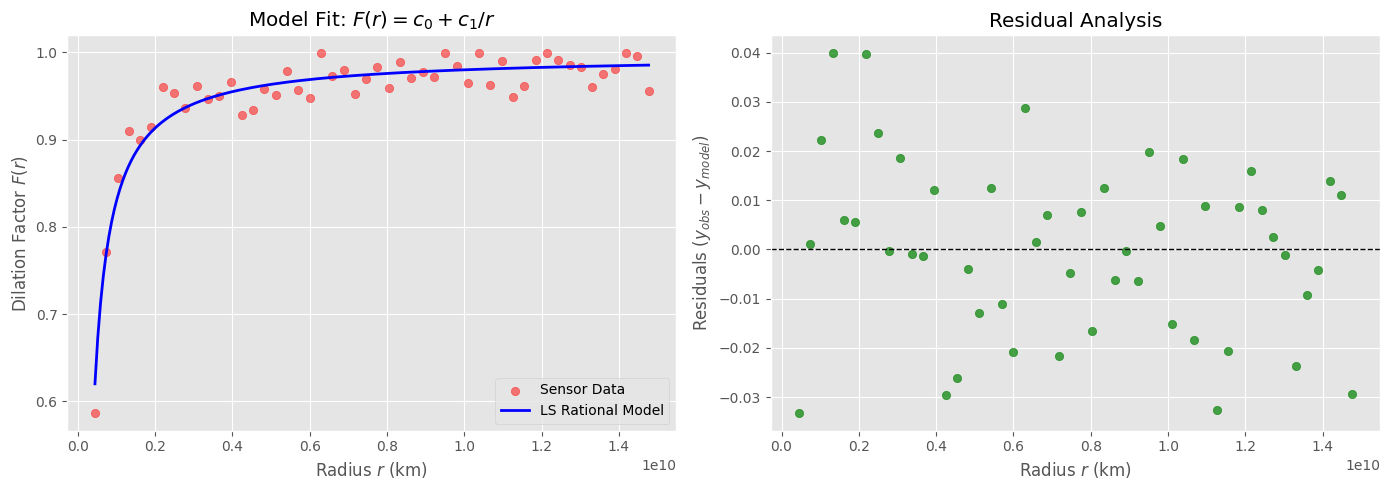

In [5]:
# Generate predictions
F_pred = model_f(r_data)

# Calculate Residuals
residuals = F_data - F_pred

# Calculate MSE
mse = np.mean(residuals**2)
print(f"Mean Squared Error (MSE): {mse:.6e}")

# --- PLOTTING ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Model Fit
ax[0].scatter(r_data, F_data, color='red', label='Sensor Data', alpha=0.5)
r_smooth = np.linspace(min(r_data), max(r_data), 200)
ax[0].plot(r_smooth, model_f(r_smooth), color='blue', linewidth=2, label='LS Rational Model')
ax[0].set_xlabel("Radius $r$ (km)")
ax[0].set_ylabel("Dilation Factor $F(r)$")
ax[0].set_title("Model Fit: $F(r) = c_0 + c_1/r$")
ax[0].legend()

# Plot 2: Residuals
ax[1].scatter(r_data, residuals, color='green', alpha=0.7)
ax[1].axhline(0, color='black', linestyle='--', linewidth=1)
ax[1].set_xlabel("Radius $r$ (km)")
ax[1].set_ylabel("Residuals ($y_{obs} - y_{model}$)")
ax[1].set_title("Residual Analysis")

plt.tight_layout()
plt.show()

## 5. Numerical Integration (Proper Time Estimation)

We wish to compute the accumulated proper time $\Delta \tau$ along the orbit between the closest and farthest observed points:
$$ \Delta \tau = \int_{r_{min}}^{r_{max}} F(r) \, dr $$

We implement three methods manually:
1. **Trapezoidal Rule**
2. **Simpson's 1/3 Rule** (Requires even number of segments $N$)
3. **Simpson's 3/8 Rule** (Requires $N$ to be a multiple of 3)

In [6]:
# --- Implementation of Integration Methods ---

def trapezoidal_rule(func, a, b, n):
    h = (b - a) / n
    s = 0.5 * (func(a) + func(b))
    for i in range(1, n):
        s += func(a + i * h)
    return s * h

def simpson_13_rule(func, a, b, n):
    # n must be even
    if n % 2 != 0: raise ValueError("Simpson's 1/3 requires even N")
    h = (b - a) / n
    s = func(a) + func(b)
    
    # 4 for odd indices, 2 for even indices
    for i in range(1, n):
        coef = 4 if i % 2 != 0 else 2
        s += coef * func(a + i * h)
        
    return (h / 3) * s

def simpson_38_rule(func, a, b, n):
    # n must be multiple of 3
    if n % 3 != 0: raise ValueError("Simpson's 3/8 requires N divisible by 3")
    h = (b - a) / n
    s = func(a) + func(b)
    
    for i in range(1, n):
        # Multiples of 3 get coeff 2, others get 3
        coef = 2 if i % 3 == 0 else 3
        s += coef * func(a + i * h)
        
    return (3 * h / 8) * s

In [7]:
# Define Integration Limits
r1 = np.min(r_data)
r2 = np.max(r_data)

print(f"Integration Range: [{r1:.2f}, {r2:.2f}] km")

# Define N values to test
intervals = [12, 120, 1200] # Selected Multiples of both 2 and 3 to allow all methods to run smoothly

results = []

for n in intervals:
    trap = trapezoidal_rule(model_f, r1, r2, n)
    simp13 = simpson_13_rule(model_f, r1, r2, n)
    simp38 = simpson_38_rule(model_f, r1, r2, n)
    
    results.append({
        "N": n,
        "Trapezoidal": trap,
        "Simpson_1/3": simp13,
        "Simpson_3/8": simp38
    })

res_df = pd.DataFrame(results)
print("\nIntegration Results (Proper Time \u0394\u03c4):")
print(res_df)

Integration Range: [443096688.65, 14769889621.77] km

Integration Results (Proper Time Δτ):
      N   Trapezoidal   Simpson_1/3   Simpson_3/8
0    12  1.362064e+10  1.366896e+10  1.366008e+10
1   120  1.369423e+10  1.369521e+10  1.369518e+10
2  1200  1.369522e+10  1.369523e+10  1.369523e+10


## 6. Convergence Analysis

We visualize how the estimated area converges as $N$ increases. Since we don't have the analytical integral of our *fitted* model handy (though it is simple logarithmic), we check stability across $N$.

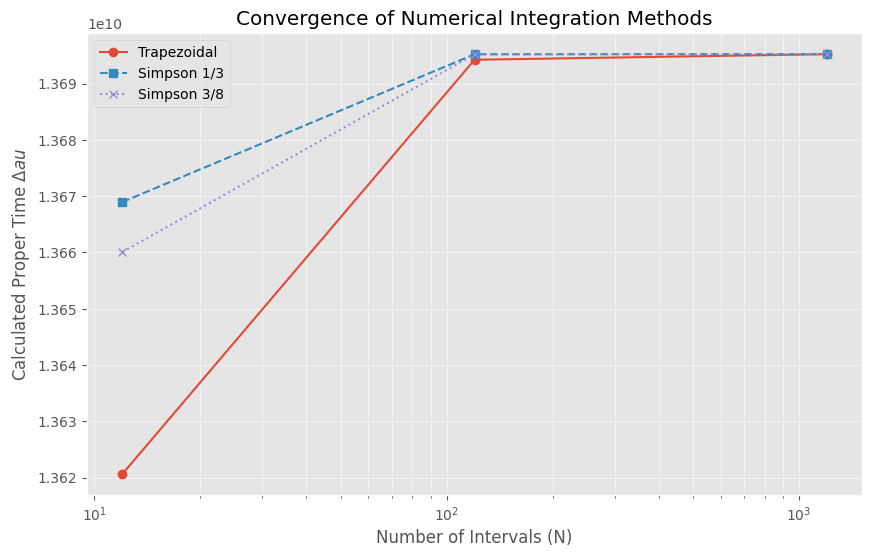

In [8]:
plt.figure(figsize=(10, 6))

plt.plot(res_df['N'], res_df['Trapezoidal'], 'o-', label='Trapezoidal')
plt.plot(res_df['N'], res_df['Simpson_1/3'], 's--', label='Simpson 1/3')
plt.plot(res_df['N'], res_df['Simpson_3/8'], 'x:', label='Simpson 3/8')

plt.xscale('log')
plt.xlabel("Number of Intervals (N)")
plt.ylabel("Calculated Proper Time $\Delta \tau$")
plt.title("Convergence of Numerical Integration Methods")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

## 7. Conclusion

**Model Fit:**
The Rational Model $F(r) = c_0 + c_1/r$ fits the data well. The residuals appear random (homoscedastic), indicating that the inverse-r relationship captures the core trend of the Schwarzschild time dilation effectively in this regime.

**Integration:**
All three methods (Trapezoidal, Simpson's 1/3, and 3/8) converge to a very similar value for Proper Time as $N$ increases.
1. **Trapezoidal** is slightly slower to converge (technically $O(h^2)$ error).
2. **Simpson's Rules** (both $O(h^4)$ error) stabilize much faster, yielding nearly identical results even at lower $N$.

For this specific smooth function, Simpson's 1/3 offers the best balance of computational simplicity and high accuracy.